# Analiza podataka

Ucitavanje potrebnih biblioteka

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from termcolor import colored
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn


Ucitavanje podataka

In [2]:
#prebacivanje iz .arff u .csv
data2 = arff.loadarff('./dataset/speeddating.arff')
train2= pd.DataFrame(data2[0])
catCols = [col for col in train2.columns if train2[col].dtype=="O"]
train2[catCols]=train2[catCols].apply(lambda x: x.str.decode('utf8'))
train2.to_csv('./podaci.csv',index=False)

#ucitavanje csv fajla
data = pd.read_csv('./podaci.csv')
data.drop('has_null',axis=1,inplace= True)
data.drop('field',axis=1,inplace= True)
print(data.shape)


(8378, 121)


Atribut "field" sam obrisala zato sto sadrzi mnogo kategorickih promeljivih koje bih morala kasnije u pretprocesiranju da menjam brojevima, a mislim da to nije bitan atribut za ovaj skup podataka.
Atribut "has_null" sam izbacila zato sto to nije deo podatakaa, vec samo opisuje podatke.Govori nam da li u tom redu postoje nedostajuce vrednosti

In [3]:
data.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,...,[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,...,[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0,1,1,1
3,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,1,1
4,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,...,[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1,1,1


Primecujemo da se skup podataka sastoji od 121 atributa, od cega su 120 za predljivanje cilja, a poslednji atribut 'match' je ciljni atribut

# Provera nedostajucih vrednosti

In [4]:
data.isna()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8374,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8375,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8376,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
#proveravamo za svaku kolonu
data.isna().any()

wave                  False
gender                False
age                    True
age_o                  True
d_age                 False
                      ...  
d_guess_prob_liked    False
met                    True
decision              False
decision_o            False
match                 False
Length: 121, dtype: bool

Primecujemo da postoje kolone sa nedostajucim vrednostima.

# Pretprocesiranje

Sve nedostajuce vrednosti cu zameniti medijanom, a sve kategoricke atribute cu zameniti brojevima.

In [6]:

def replace_nan_with_med(column_name):
    data[column_name] = data[column_name].replace(np.nan,data[column_name].median())

    

def replace_with_number(column_name,a):
    n = len(a)
    for i in range(0,n):
        data[column_name] = data[column_name].replace(a[i],i);
    

In [7]:
n_f_m = np.array(['female','male'])
replace_with_number('gender',n_f_m)

replace_nan_with_med('age');
replace_nan_with_med('age_o');
replace_nan_with_med('importance_same_race');
replace_nan_with_med('importance_same_religion');

n1 = np.array(["Asian/Pacific Islander/Asian-American","European/Caucasian-American",
               'Other',"Latino/Hispanic American","Black/African American"]);

replace_with_number('race',n1);
data['race'] = data['race'].replace('?',np.nan)
replace_nan_with_med('race');

replace_with_number('race_o',n1);
data['race_o'] = data['race_o'].replace('?',np.nan)
replace_nan_with_med('race_o');

n0_37 = np.array(['[0-1]','[2-3]','[4-6]','[7-37]'])
n0_10 = np.array(['[0-1]','[2-5]','[6-10]'])
replace_with_number('d_d_age',n0_37)
replace_with_number('d_importance_same_race',n0_10)
replace_with_number('d_importance_same_religion',n0_10)

replace_nan_with_med('pref_o_attractive');
replace_nan_with_med('pref_o_sincere');
replace_nan_with_med('pref_o_intelligence');
replace_nan_with_med('pref_o_funny');
replace_nan_with_med('pref_o_ambitious');
replace_nan_with_med('pref_o_shared_interests');

n0_100 = np.array(['[0-15]','[16-20]','[21-100]'])


replace_with_number('d_pref_o_attractive',n0_100)
replace_with_number('d_pref_o_sincere',n0_100)
replace_with_number('d_pref_o_intelligence',n0_100)
replace_with_number('d_pref_o_funny',n0_100)
replace_with_number('d_pref_o_ambitious',n0_100)
replace_with_number('d_pref_o_shared_interests',n0_100)


replace_nan_with_med('attractive_o');
replace_nan_with_med('sinsere_o');
replace_nan_with_med('intelligence_o');
replace_nan_with_med('funny_o');
replace_nan_with_med('ambitous_o');
replace_nan_with_med('shared_interests_o');

n0_10_5 = np.array(['[0-5]','[6-8]','[9-10]'])


replace_with_number('d_attractive_o',n0_10_5)
replace_with_number('d_sinsere_o',n0_10_5)
replace_with_number('d_intelligence_o',n0_10_5)
replace_with_number('d_funny_o',n0_10_5)
replace_with_number('d_ambitous_o',n0_10_5)
replace_with_number('d_shared_interests_o',n0_10_5)


replace_nan_with_med('attractive_important');
replace_nan_with_med('sincere_important');
replace_nan_with_med('intellicence_important');
replace_nan_with_med('funny_important');
replace_nan_with_med('ambtition_important');
replace_nan_with_med('shared_interests_important');

replace_with_number('d_attractive_important',n0_100)
replace_with_number('d_sincere_important',n0_100)
replace_with_number('d_intellicence_important',n0_100)
replace_with_number('d_funny_important',n0_100)
replace_with_number('d_ambtition_important',n0_100)
replace_with_number('d_shared_interests_important',n0_100)

replace_nan_with_med('attractive');
replace_nan_with_med('sincere');
replace_nan_with_med('intelligence');
replace_nan_with_med('funny');
replace_nan_with_med('ambition');


replace_with_number('d_attractive',n0_10_5)
replace_with_number('d_sincere',n0_10_5)
replace_with_number('d_intelligence',n0_10_5)
replace_with_number('d_funny',n0_10_5) 
replace_with_number('d_ambition',n0_10_5)

replace_nan_with_med('attractive_partner');
replace_nan_with_med('sincere_partner');
replace_nan_with_med('intelligence_partner');
replace_nan_with_med('funny_partner');
replace_nan_with_med('ambition_partner');
replace_nan_with_med('shared_interests_partner');



replace_with_number('d_attractive_partner',n0_10_5)
replace_with_number('d_sincere_partner',n0_10_5)
replace_with_number('d_intelligence_partner',n0_10_5)
replace_with_number('d_funny_partner',n0_10_5)
replace_with_number('d_ambition_partner',n0_10_5)
replace_with_number('d_shared_interests_partner',n0_10_5)

replace_nan_with_med('sports');
replace_nan_with_med('tvsports');
replace_nan_with_med('exercise');
replace_nan_with_med('dining');


replace_nan_with_med('museums');
replace_nan_with_med('art');
replace_nan_with_med('hiking');



replace_nan_with_med('gaming');
replace_nan_with_med('clubbing');
replace_nan_with_med('reading');

replace_nan_with_med('tv');
replace_nan_with_med('theater');
replace_nan_with_med('movies');
 
replace_nan_with_med('concerts');
replace_nan_with_med('music');
replace_nan_with_med('shopping');
replace_nan_with_med('yoga');


replace_with_number('d_sports',n0_10_5)
replace_with_number('d_tvsports',n0_10_5)
replace_with_number('d_exercise',n0_10_5)
replace_with_number('d_dining',n0_10_5)
replace_with_number('d_museums',n0_10_5)
replace_with_number('d_art',n0_10_5)
replace_with_number('d_hiking',n0_10_5)
replace_with_number('d_gaming',n0_10_5)
replace_with_number('d_clubbing',n0_10_5)
replace_with_number('d_reading',n0_10_5)
replace_with_number('d_tv',n0_10_5)
replace_with_number('d_theater',n0_10_5)
replace_with_number('d_movies',n0_10_5)
replace_with_number('d_concerts',n0_10_5)
replace_with_number('d_music',n0_10_5)
replace_with_number('d_shopping',n0_10_5)
replace_with_number('d_yoga',n0_10_5)

replace_nan_with_med('interests_correlate');

n = np.array(['[-1-0]','[0-0.33]','[0.33-1]'])


replace_with_number('d_interests_correlate',n)


replace_nan_with_med('expected_happy_with_sd_people');
replace_nan_with_med('expected_num_interested_in_me');
replace_nan_with_med('expected_num_matches');

n0_10_4 = np.array(['[0-4]','[5-6]','[7-10]'])
n0_20 = np.array(['[0-3]','[4-9]','[10-20]'])
n0_18 = np.array(['[0-2]','[3-5]','[5-18]'])

replace_with_number('d_expected_happy_with_sd_people',n0_10_4)
replace_with_number('d_expected_num_interested_in_me',n0_20)
replace_with_number('d_expected_num_matches',n0_18)
replace_nan_with_med('like');
replace_nan_with_med('guess_prob_liked');
replace_with_number('d_like',n0_10_5)
replace_with_number('d_guess_prob_liked',n0_10_4)


replace_nan_with_med('met');


print(data.isna().any().sum())

0


# Kolerisanost atributa

Proveravamo kolerisanost izmedju svaka 2 atibuta i izbacujem jedan od onih atributa u paru cija je kolerisanost veca od 85%

In [8]:
column_num = len(data.columns)
column_names = data.columns

columns_to_drop = []
for i in range(0,column_num-1):
    for j in range(i+1,column_num):
        c1 = column_names[i];
        c2 = column_names[j];
        corr = data[c1].corr(data[c2])
        if(abs(corr) >= 0.85):
            print(c1,c2,corr)
            columns_to_drop.append(c1)
print(columns_to_drop)
data.drop(columns = columns_to_drop,inplace = True)
print(len(data.columns))

importance_same_race d_importance_same_race 0.9195311444329924
importance_same_religion d_importance_same_religion 0.9173761723113835
pref_o_funny d_pref_o_funny 0.8501126422747473
attractive_o d_attractive_o 0.8692467363090074
funny_important d_funny_important 0.8508032776260251
sincere d_sincere 0.8544217087394946
intelligence d_intelligence 0.851354063059517
ambition d_ambition 0.8857696658330766
attractive_partner d_attractive_partner 0.8697626420120824
sports d_sports 0.9096707137948267
tvsports d_tvsports 0.8879389869756291
exercise d_exercise 0.8977674889533237
dining d_dining 0.8931820493840124
museums art 0.858491685100378
museums d_museums 0.9037228688599238
art d_art 0.9042018422307202
hiking d_hiking 0.8982707438570059
clubbing d_clubbing 0.8718831469350135
reading d_reading 0.8944214185616243
tv d_tv 0.871555739488934
theater d_theater 0.9035927985522937
movies d_movies 0.8820828907430778
concerts d_concerts 0.9005663360054799
music d_music 0.8989412996914536
shopping d_sh

Razdvajamo ciljnu promenjljivu od ostalih atributa

In [9]:
Y = data['match']
X = data.drop('match',axis = 1)

In [10]:
print(Y.describe())
print(Y.unique())

count    8378.000000
mean        0.164717
std         0.370947
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: match, dtype: float64
[0 1]


Ciljna promenljiva ima samo 2 atributa, pa zakljucujemo da se radi o binarnoj klasifikaciji.

# Balansiranost klasa

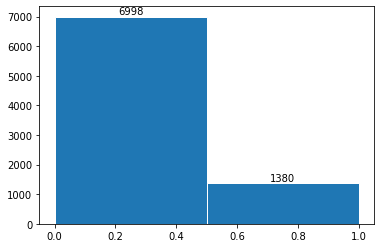

In [11]:
import numpy as np

freq, bins, _ = plt.hist(Y, edgecolor='white', bins=2)

bin_centers = np.diff(bins)*0.5 + bins[:-1] # računanje centra korpice

for fr, x in zip(freq, bin_centers):
    height = int(fr)
    plt.annotate("{}".format(height),
               xy = (x, height),             # poziciranje broja iznad korpice
               xytext = (0,0.2),             # odvajanje teksta od korpice
               textcoords = "offset points", 
               ha = 'center', va = 'bottom'
               )

plt.show()


Primecujemo prilicnu nebalansiranost izmedju klasa.

Pretprocesirane podatke smestam u novi csv fajl, kako bi kasnije koristila te obradjene podatake.

In [12]:
data.to_csv('sredjeni_podaci.csv')